**Goal:** To run predict attendance and identify important features using a baseball schedule, random forest and local outlier factor models
  <br><br>
**Description:** This purpose of this project was to predict attendance using a baseball schedule.  Two differentCSV files were cleaned, wrangled, and combined to form the data set. A Local Outlier Factor (LOF) unsupervised learning model was applied to remove outliers in the data. The data with and without the LOF applied was fed through a Random Forest Regression (RF) model and the outcomes were compared to see if the LOF improved the performance of the RF models. The two outcomes were compared using RMSE, MSE, MAE and R2 to compare the model fit The top 10 most important features to both models were identified.
 <br> <br>
**Skills:** Data Cleaning and Wrangling, Data Visualization, Random Forest Regression, Local Outlier Factor, Machine Learning
 <br> <br>
**Technology:** Python, Matplotlib, Seaborn, Numpy, Pandas, Scikit-learn
<br> <br>
**Result:** Overall, the models did a good job with the prediction. Applying the local outlier factor to remove outliers prior to the random forest application did show some improvements over a random forest only model. Looking at the predicted vs actual plots, there were still outliers present, but most of the points were clustered around the ideal line. The most important feature to both the RF and RF&LOF models was the day of the week of the game. This is a somewhat unsurprising result because one would expect higher attendance at games that occur on the weekend. Both game day and game month were in the top 10 features, but not the game hour meaning the day and month were more important to our model than the hour the game started. The rest of the top 10 most important feature spots were taken by various home teams. Home team is a large predictor of attendance in both models


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

Creates a readData function to perform basic exploratory data analysis.

In [ ]:
'''
Function: readData(file)

Purpose: reads a CSV file, creates dataframe and prints
the first 5 rows, column names and number of rows and columns

Input: File name for a .csv file

Return: a pandas dataframe

'''

def readData(file):
    #creates a header on the output for organization
    print('\n\n', '*' * 10, 'readData(',file,')', '*' * 10, '\n\n')

    # reads .csv file into a pandas data frame or prints exception
    try:
        dataFrame = pd.read_csv(file)
    except:
        print('Unable to create dataframe from ', file)

    # prints the first 5 rows
    print('The first 5 rows are: \n', dataFrame.head(5), '\n')

    # print the file's column names
    print('The file column names are \n', dataFrame.columns, '\n')

    # prints the number of rows and columns
    print('There are ', dataFrame.shape[0], ' rows and ', dataFrame.shape[1], ' Columns\n')

    # prints a break-line to separate output
    print('*' * 10, 'End readData(', file, ')', '*' * 10, '\n\n')

    return dataFrame


I created a fixColumns1 function to drop unnecessary columns and rename existing columns on the first CSV file to match a standardized format.

In [ ]:
'''
Function: fixColumns1(file)

Purpose: extracts the columns needed and renames columns to match other file

Input: a pandas data frame

Return: an updated pandas dataframe

'''

def fixColumns1(dataFrame):
    #prints header
    print('*' * 10, 'fixColumns1', '*' * 10)

    #drops unneeded columns
    dataFrame = dataFrame.drop(columns=['id','created','gameNumber', 'seasonId','year', 'type', 'duration',
                                          'duration_minutes', 'homeId','awayId','status','comment' ])

    #rennames columns
    dataFrame.rename(columns={'homeName': 'homeTeamName', 'awayName': 'awayTeamName', 'started':'startTime'}
                     , inplace=True)

    #prints new columns headers to confirm
    print('The updated columns in dataframe 1 are:', dataFrame.columns)

    #prints break-line for organization
    print('*' * 10, 'End fixColumns1', '*' * 10, '\n\n')
    return dataFrame


The fixColumns2 function was created to perform the same functions as fixColums1 function, but for the second CSV file.

In [ ]:

'''
Function: fixColumns2(file)

Purpose: extracts the columns needed and renames columns to match other file

Input: a pandas data frame

Return: an updated pandas dataframe

'''

def fixColumns2(dataFrame):
    #prints header
    print('*' * 10, 'fixColumns2', '*' * 10)

    #drops unneeded columns
    dataFrame = dataFrame.drop(columns=[ 'gameId','gameNumber', 'seasonId', 'year', 'type', 'length',
                                          'length_mins', 'homeTeamId','awayTeamId', 'status', 'added'])

    #renames columns
    dataFrame.rename(columns={'dayNight': 'day_or_night'},inplace=True)

    #prints updated column headers to confirm
    print('The updated columns in dataframe 2 are:', dataFrame.columns)

    #prints break-line
    print('*' * 10, 'End fixColumns2', '*' * 10, '\n\n')
    return dataFrame



ConcatData function was created to concatenate the two .CSV files into one master file and then perform basic EDA to confirm the files were merged successfully.

In [ ]:
'''
Function: concatData(d1,d2)

Purpose: merges the two dataframes and then prints first 5 rows, column names
and number of rows and columns and counts of columns

Input: two pandas dataframes

Return: a single merged pandas dataframe

'''

def concatData(d1,d2):
    #prints a header for organization of output
    print('\n\n', '*' * 10,'Concatenated Data Frame', '*' * 10, '\n\n')

    #concatenates the two dataframes into one
    dataFrame=pd.concat([d1,d2],ignore_index= True)

    # prints the first 5 rows
    print('The first 5 rows are: \n', dataFrame.head(5), '\n')

    # print the file's column names
    print('The file column names are \n', dataFrame.columns, '\n')

    # prints the number of rows and columns
    print('There are ', dataFrame.shape[0], ' rows and ', dataFrame.shape[1], ' Columns\n')

    #prints counts of columns
    print('Data count\n', dataFrame.count(), '\n')

    # prints a break-line to separate output
    print('*' * 10, 'End Concatenate Data Frame Exploration', '*' * 10, '\n\n')
    return dataFrame


Once the two CSV files were merged into one dataframe, the CleanConcatData function will drop rows with missing values, duplicate rows and rows with invalid values as well as printing an updated EDA to confirm it was done correctly.


In [ ]:
'''
Function: cleanConcatData(df)

Purpose: drops rows with missing values, duplicate rows and rows with invalid day_or_night values.
prints updated exploratory analysis

Input: a pandas dataframes

Return: a pandas dataframe

'''

def cleanConcatData(df):
    # prints a header for organization of output
    print('\n\n', '*' * 10, 'cleanConcatData', '*' * 10, '\n\n')

    # drops rows with missing values
    df.dropna(inplace=True)

    # prints the duplicated Id's row
    print('\nThe duplicated games are:\n', df.loc[df.duplicated(), :])

    # drops any duplicate rows keeping only the first
    df.drop_duplicates(keep='first', inplace=True)

    #drops any row where day_or_night is neither D nor N
    df.drop(df.loc[(df.day_or_night != "D") & (df.day_or_night != "N") ].index, inplace=True)

    # prints the first 5 rows
    print('The first 5 rows are: \n', df.head(5), '\n')

    # print the file's column names
    print('The file column names are \n', df.columns, '\n')

    # prints the number of rows and columns
    print('There are ', df.shape[0], ' rows and ', df.shape[1], ' Columns\n')

    print('Data count after cleaning \n', df.count(), '\n')

    # prints a Footer for organization of output
    print('\n\n', '*' * 10, 'End cleanConcatData', '*' * 10, '\n\n')
    return df


The formatData function extracts the weekday, game month and hour from the startTime column. After dropping the now unnecessary startTime column, the remaining categorical columns are one-hot encoded.

In [ ]:
'''
Function: formatData(df)

Purpose: extracts weekday and game month from dataframe startTime and drops startTime.
one hot encodes categorical columns: 'day_or_night','homeTeamName','awayTeamName'

Input: a pandas dataframes

Return: encoded dataframe

'''

def formatData(df):
    print('\n\n', '*' * 10, 'Format Data', '*' * 10, '\n\n')
    #formates startTime column into datetime format
    df['startTime'] = pd.to_datetime(df['startTime'], format= "%Y-%m-%dT%H:%M:%SZ")

    #creates a weekday column where values range from 0 (for monday) to 6 (for sunday)
    df['weekday']= df['startTime'].dt.dayofweek

    #creates a month column
    df['gameMonth']= df.startTime.dt.month

    # creates a month column
    df['gameDay'] = df.startTime.dt.day

    # creates an hour column
    df['gameHour'] = df.startTime.dt.hour

    #drops startTime column because we have extracted weekday and month
    df = df.drop(columns=['startTime'])

    #encodes categorical columns with one hot encoding
    df_encoded = pd.get_dummies(df, columns=['day_or_night', 'homeTeamName', 'awayTeamName'],dtype=int,
                                drop_first= True)

    # prints the first 5 rows
    print('The first 5 rows are: \n', df_encoded.head(5), '\n')

    # print the file's column names
    print('The file column names are \n', df_encoded.columns, '\n')

    # prints the number of rows and columns
    print('There are ', df_encoded.shape[0], ' rows and ', df_encoded.shape[1], ' Columns\n')

    print('Data count after formatting \n', df_encoded.count(), '\n')

    print('\n\n', '*' * 10, 'End Format Data', '*' * 10, '\n\n')
    return df_encoded




The dataframe was then run through a local outlier factor model to remove local outliers from the dataset.

In [ ]:
'''
Function: localOutlierFactorModel(df)

Purpose: Runs local outlier factor model to identify and remove outliers

Input: a pandas dataframes

Return: X, y, X_cleaned, y_cleaned

'''

def localOutlierFactorModel(df):
    # prints a header for organization of output
    print('\n\n', '*' * 10, 'localOutlierFactorModel', '*' * 10, '\n\n')

    #creates and X dataset prior to removing outlier
    X = df.drop(columns=['attendance'], axis=1)

    #applies standard scaler to X data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # defines target variable y prior to removing outliers
    y = df[['attendance']]

    #initializes local outlier factor model
    lof = LocalOutlierFactor(n_neighbors=10)

    # Fit the model
    lof.fit(X_scaled, y)

    # Predict using the best model
    outlierScores = lof.fit_predict(X_scaled)

    # creates boolean mask to identify outliers using outlier scores.
    outlier_mask = outlierScores != -1

    # creates cleaned dataset with outlier removed using mask
    X_cleaned, y_cleaned = X[outlier_mask], y[outlier_mask]

    #y_cleaned.to_csv('cleaned data y.csv')

    #prints footer to organize output
    print('\n\n', '*' * 10, 'End localOutlierFactorModel', '*' * 10, '\n\n')

    return X, y, X_cleaned, y_cleaned





I created a generic randomForestModel function because I will be running two different sets of data through it. It will be run with the original cleaned dataframe as well as the dataframe after outlier removal from the local outlier factor.

In [ ]:
'''
Function: randomForestModel(X, y, modelTitle)

Purpose: Runs a random Forest regression and extracts y_test, feature importance and Y_predict

Input: X, y, modelTitle

Return: y_test, y_predict, dfFeatureImportance

'''

def randomForestModel(X, y, modelTitle):
    print('\n\n', '*' * 10, 'RandomForestModel:', modelTitle, '*' * 10, '\n\n')

    # splits my original data to training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=123)

    #initializes random forest regression model
    rfReg = RandomForestRegressor(n_estimators=100, random_state=123)

    # fits my random forest regression model on training data
    rfReg = rfReg.fit(X_train, np.ravel(y_train, order='C'))

    #predicts using testing data
    y_predict = rfReg.predict(X_test)

    # creates list of feature importance
    dfFeatureImportance = pd.DataFrame(rfReg.feature_importances_, index=X.columns,columns=['Feature Score'])

    # sorts feature importance in descending order
    dfFeatureImportance.sort_values(by='Feature Score', ascending=False, inplace=True)

    #prints list of most important features
    print('The top 10 most important features in the ', modelTitle, ' model\n', dfFeatureImportance.head(10))

    #prints footer for output organization
    print('\n\n', '*' * 10, 'End RandomForestModel:', modelTitle, '*' * 10, '\n\n')
    return  y_test, y_predict, dfFeatureImportance



I created a compareMetrics function to compare the values of the RMSE,MSE, MAE and R2 values for the RF only and RF & LOF model.

In [ ]:
'''
Function: compareMetrics(y_test, y_predict_baseline , y_test_cleaned, y_predict_cleaned)

Purpose: Prints a chart of metrics comparing RF only model with RF and LOF model

Input: y_test, y_predict_baseline , y_test_cleaned, y_predict_cleaned

Return: None

'''

def compareMetrics(y_test, y_predict_baseline , y_test_cleaned, y_predict_cleaned):

    #prints header for output organization
    print('\n\n', '*' * 10, 'compareMetrics', '*' * 10, '\n\n')

    #sets pandas float format to prevent scientific notation on metric chart
    pd.options.display.float_format = '{:20,.4f}'.format

    #removes limit on columns
    pd.set_option('display.max_columns', None)

    #calculates metrics for the baseline RF data: RMSE, MSE, MAE, R2
    rmse_baseline = root_mean_squared_error(y_test, y_predict_baseline)
    mse_baseline = mean_squared_error(y_test, y_predict_baseline)
    mae_baseline = mean_absolute_error(y_test, y_predict_baseline)
    r2_baseline = r2_score(y_test, y_predict_baseline)

    #calculates metrics for the RF & LOF data: RMSE, MSE, MAE, R2
    rmse_cleaned = root_mean_squared_error(y_test_cleaned, y_predict_cleaned)
    mse_cleaned = mean_squared_error(y_test_cleaned, y_predict_cleaned)
    mae_cleaned = mean_absolute_error(y_test_cleaned, y_predict_cleaned)
    r2_cleaned = r2_score(y_test_cleaned,y_predict_cleaned)


    #calculates % difference between the baseline RF  and RF & LOF models
    percentDiffRMSE = ((rmse_cleaned-rmse_baseline)/rmse_baseline) *100
    percentDiffMSE= ((mse_cleaned-mse_baseline)/mse_baseline) *100
    percentDiffMAE= ((mae_cleaned-mae_baseline)/mae_baseline) * 100
    percentDiffR2= ((r2_cleaned-r2_baseline)/r2_baseline) * 100


    #creates dictionary of metrics
    metrics = {
        'Metric': ['Root Mean Squared Error','Mean Squared Error', 'Mean Absolute Error', 'R2 Score'],
        'RF Only': [rmse_baseline,mse_baseline, mae_baseline, r2_baseline],
        'RF & LOF': [rmse_cleaned,mse_cleaned, mae_cleaned, r2_cleaned],
        '% Difference': [ percentDiffRMSE,percentDiffMSE,percentDiffMAE,percentDiffR2]
    }

    #turns metric dictionary to dataframe for formatting and prints
    print(pd.DataFrame(metrics))

    # prints header for output organization
    print('\n\n', '*' * 10, 'End compareMetrics', '*' * 10, '\n\n')




This function visualizes the predicted vs actual graphs for both the RF only and RF&LOF models, plots them side by side and adds ideal line.

In [ ]:
'''
Function: visualizePrediction(y_test, y_predict_baseline, y_test_cleaned, y_predict_cleaned)

Purpose: creates a predicted Y vs actual Y for baseline and cleaned and plots side by side

Input: y_test, y_predict_baseline, y_test_cleaned, y_predict_cleaned

Return: None

'''

def visualizePrediction(y_test, y_predict_baseline, y_test_cleaned, y_predict_cleaned):



    ############ RF only Model Plot##########################
    #identifies placement in side by side plot
    plt.subplot(1, 2, 1)

    # Plot Baseline Actual vs predicted
    plt.scatter(y_test, y_predict_baseline, s=50)

    #plots ideal line
    plt.axline((0, 0), slope=1, color='m', linestyle='--')

    # creates title of the plot
    plt.title('Random Forest Model Only\n Predicted vs Actual')

    # labels the x-axis on plot
    plt.xlabel('Actual Values: RF Only')

    # labels the y-axis on plot
    plt.ylabel('Predicted Values: RF only')



    ############ RF & LOF Model Plot##########################
    # identifies placement in side by side plot
    plt.subplot(1, 2, 2)

    # Plot Baseline Actual vs predicted
    plt.scatter(y_test_cleaned, y_predict_cleaned, s=50)

    # plots ideal line
    plt.axline((0, 0), slope=1, color='m', linestyle='--')

    # creates title of the plot
    plt.title('Random Forest and Local Outlier Factor Model \n Predicted vs Actual')

    # labels the x-axis on plot
    plt.xlabel('Actual Values: RF & LOF')

    # labels the y-axis on plot
    plt.ylabel('Predicted Values: RF & LOF')

    # shows the scatter plot
    plt.show()


This function will visualize the feature importance scores for the top 10 most important features in our model. It is important to note that since we one-hot encoded the categorical variables, we will features for each home and each away team etc.. which are all addressed individually.

In [ ]:
'''
Function: visualizeImportantFeatures(dfFeatureImportance_cleaned)

Purpose: creates bar chart for top 10 most important features to FR & LOF model

Input: dfFeatureImportance_cleaned

Return: None

'''

def visualizeImportantFeatures(dfFeatureImportance_cleaned):

    #creates list of the top 10 feature names
    names = dfFeatureImportance_cleaned.head(10).index

    # creates list of the top 10 importance scores
    importance = dfFeatureImportance_baseline['Feature Score'].head(10).tolist()

    #creates plot
    ax = sns.barplot(x= importance, y= names, orient='h')
    # Plot Baseline Actual vs predicted

    # creates title of the plot
    plt.title('Top 10 Model Features\nRandom Forest & LOF')

    # labels the x-axis on plot
    plt.xlabel('Importance')
    ax.tick_params(axis='y', labelrotation=45)

    # labels the y-axis on plot
    plt.ylabel('Feature Name')

    #shows the plot
    plt.show()


Now that all the functions are defined, we will start applying the functions to the .CSV files. Both .CSV files are read into data frames which are then cleaned, wrangled, combined and formatted.

In [ ]:
#### Data Cleaning and Wrangling ####


#reads baseball schedule file 1 and performs exploratory analysis
df1 = readData('Baseball_Schedule_file1.csv')

#reads baseball schedule file 2 and performs exploratory analysis
df2 = readData('Baseball_Schedule_file2.csv')

#calls fixColumns1 to drop unneeded columns and rename columns in first data frame
df1=fixColumns1(df1)

#calls fixColumns2 to drop unneeded columns and rename columns in second data frame
df2=fixColumns2(df2)

#calls concatData to merge the two dataframes together
df=concatData(df1,df2)

#calls cleanConcatData function to drop rows with missing, duplicated or invalid data
df= cleanConcatData(df)

#calls format data function to
df= formatData(df)



 ********** readData( Baseball_Schedule_file1.csv ) ********** 


The first 5 rows are: 
                                      id               created  gameNumber  \
0  e14b6493-9e7f-404f-840a-8a680cc364bf  2016-10-06T06:25:15Z           1   
1  1f32b347-cbcb-4c31-a145-0e685306d168  2016-10-06T06:25:15Z           1   
2  0c2292d1-7398-48be-bf8e-b41dad5e1a43  2016-10-06T06:25:15Z           1   
3  8fbec734-a15a-42ab-8d51-60790de7750b  2016-10-06T06:25:15Z           1   
4  89e514d5-fbf5-4b9d-bdac-6ca45bfd18dd  2016-10-06T06:25:15Z           1   

                               seasonId    year type day_or_night duration  \
0  565de4be-dc80-4849-a7e1-54bc79156cc8  2016.0  REG            D  5000XYZ   
1  565de4be-dc80-4849-a7e1-54bc79156cc8  2016.0  REG            D     3:09   
2  565de4be-dc80-4849-a7e1-54bc79156cc8  2016.0  REG            D     2:45   
3  565de4be-dc80-4849-a7e1-54bc79156cc8  2016.0  REG            D     3:42   
4  565de4be-dc80-4849-a7e1-54bc79156cc8  2016.0  REG   

After the data wrangling is completed, the data is then run through the RF only model and the RF&LOF model. The two models are compared based on their RMSE,MAE, RME and R2 scores and the plots for both are visualized to see if there is significant improvement.



 ********** localOutlierFactorModel ********** 




 ********** End localOutlierFactorModel ********** 




 ********** RandomForestModel: Random Forest Only ********** 


The top 10 most important features in the  Random Forest Only  model
                         Feature Score
weekday                      0.100386
homeTeamName_Dodgers         0.073515
homeTeamName_Rays            0.070880
homeTeamName_Cardinals       0.058416
homeTeamName_Blue Jays       0.058122
gameMonth                    0.052888
gameDay                      0.052001
homeTeamName_Giants          0.051427
homeTeamName_Athletics       0.050256
homeTeamName_Cubs            0.044722


 ********** End RandomForestModel: Random Forest Only ********** 




 ********** RandomForestModel: Random Forest and LOF ********** 


The top 10 most important features in the  Random Forest and LOF  model
                         Feature Score
weekday                      0.103303
homeTeamName_Dodgers         0.080317
homeTeamName

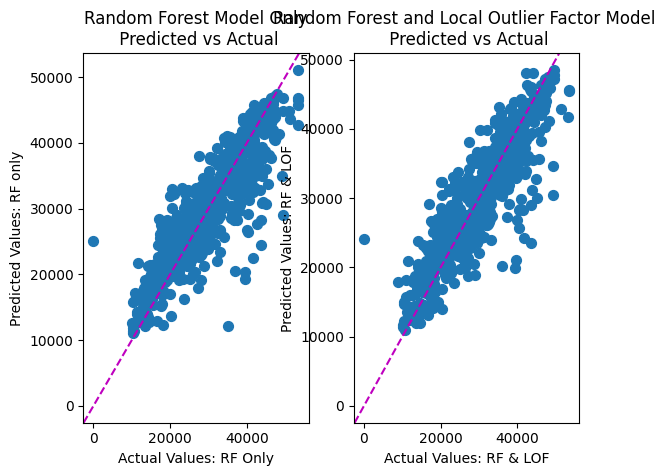

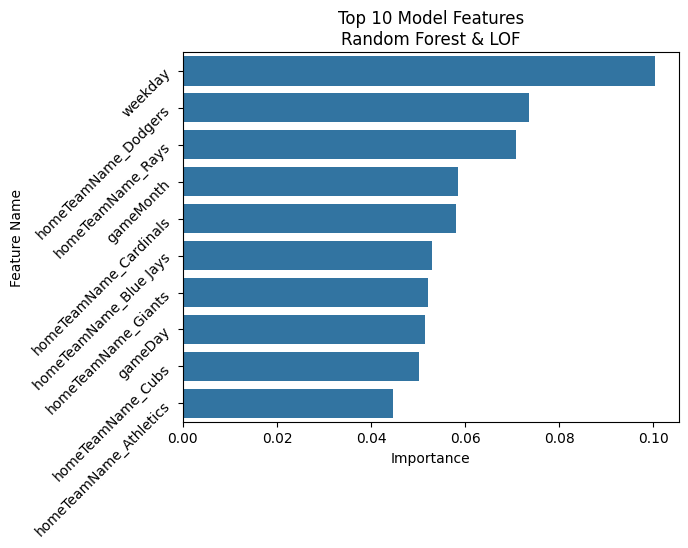

In [ ]:
#####  Model Running and visualizations #####


#calls local outlier factor function to remove outliers
X, y, X_cleaned, y_cleaned = localOutlierFactorModel(df)

#calls randomForestModel function for RF only model
y_test, y_predict_baseline, dfFeatureImportance_baseline = randomForestModel(X, y,'Random Forest Only')

#calls randomForestModel function for RF & LOF model
y_test_cleaned, y_predict_cleaned,dfFeatureImportance_cleaned = randomForestModel( X_cleaned, y_cleaned, 'Random Forest and LOF')

#calls compareMetrics function to compare metrics for baseline RF and RF & LOF models
compareMetrics(y_test, y_predict_baseline , y_test_cleaned, y_predict_cleaned)

#calls visualizePrediction to make scatter plots of predicted vs actual values
visualizePrediction(y_test, y_predict_baseline, y_test_cleaned, y_predict_cleaned)

#visualization for important features to models
visualizeImportantFeatures( dfFeatureImportance_cleaned)

#Exports cleaned data frame to .csv file
df.to_csv("haensch_final_project.csv",index=False)
